In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

ds_train = datasets.ImageFolder("/datasets/kaggle-car-truck/train", transform=transform)
ds_valid = datasets.ImageFolder("/datasets/kaggle-car-truck/valid", transform=transform)

dl_train = DataLoader(ds_train, batch_size=64, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=64, shuffle=True)

dl_dict = {"train": dl_train, "valid": dl_valid}

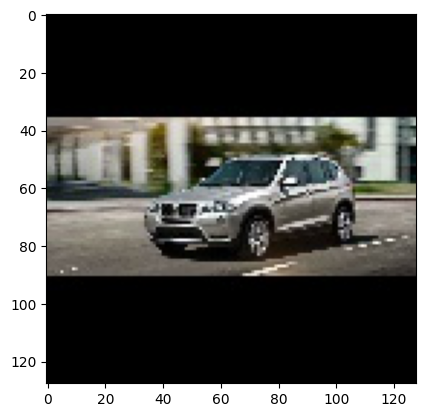

In [3]:
for images, labels in dl_train:
    plt.imshow(images[0].numpy().transpose((1, 2, 0)))
    break

In [9]:
import torch.nn as nn
from torchvision.models.vgg import vgg16


weights = models.VGG16_Weights.IMAGENET1K_FEATURES

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.preprocess = weights.transforms()
        self.vgg = vgg16(weights=weights, progress=True)
        self.vgg.classifier[6] = nn.Linear(4096, 2)

        for m in self.vgg.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

        for param in self.vgg.features.parameters():
            param.requires_grad = False
        for param in self.vgg.avgpool.parameters():
            param.requires_grad = False
        for param in self.vgg.classifier.parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.preprocess(x)
        x = self.vgg(x)
        return x


net = Net()
net.train()

Net(
  (preprocess): ImageClassification(
      crop_size=[224]
      resize_size=[256]
      mean=[0.48235, 0.45882, 0.40784]
      std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098]
      interpolation=InterpolationMode.BILINEAR
  )
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace

In [10]:
from torch import optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.vgg.classifier.parameters(), lr=1e-3, momentum=0.9)

In [11]:
from tqdm import tqdm

device = torch.device("cuda")
net = net.to(device)

accuracy_list = []
loss_list = []

num_epochs = 30
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-------------')

    for phase in ["train", "valid"]:
        if phase == "train":
            net.train()
        else:
            net.eval()

        epoch_loss = 0.0
        epoch_corrects = 0

        for inputs, labels in tqdm(dl_dict[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = net(inputs)

                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                epoch_loss += loss.item() * inputs.size(0)  
                epoch_corrects += torch.sum(preds == labels.data)

        epoch_loss = epoch_loss / len(dl_dict[phase].dataset)
        epoch_acc = epoch_corrects.double() / len(dl_dict[phase].dataset)

        if phase == 'valid':
            accuracy_list.append(epoch_acc.item())
            loss_list.append(epoch_loss)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

Epoch 1/30
-------------


  0%|          | 0/80 [00:00<?, ?it/s]/home/nikita/tools/miniconda3/envs/lidar/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 80/80 [00:37<00:00,  2.11it/s]


train Loss: 3.4918 Acc: 0.7827


100%|██████████| 79/79 [00:35<00:00,  2.25it/s]


valid Loss: 0.7906 Acc: 0.8854
Epoch 2/30
-------------


100%|██████████| 80/80 [00:38<00:00,  2.10it/s]


train Loss: 0.9176 Acc: 0.8771


100%|██████████| 79/79 [00:35<00:00,  2.24it/s]


valid Loss: 0.5331 Acc: 0.8870
Epoch 3/30
-------------


100%|██████████| 80/80 [00:38<00:00,  2.09it/s]


train Loss: 0.2723 Acc: 0.9332


100%|██████████| 79/79 [00:35<00:00,  2.24it/s]


valid Loss: 0.2213 Acc: 0.9285
Epoch 4/30
-------------


100%|██████████| 80/80 [00:38<00:00,  2.09it/s]


train Loss: 0.1192 Acc: 0.9615


100%|██████████| 79/79 [00:35<00:00,  2.24it/s]


valid Loss: 0.2301 Acc: 0.9384
Epoch 5/30
-------------


100%|██████████| 80/80 [00:38<00:00,  2.09it/s]


train Loss: 0.0642 Acc: 0.9781


100%|██████████| 79/79 [00:35<00:00,  2.24it/s]


valid Loss: 0.2057 Acc: 0.9366
Epoch 6/30
-------------


100%|██████████| 80/80 [00:38<00:00,  2.10it/s]


train Loss: 0.0393 Acc: 0.9869


100%|██████████| 79/79 [00:35<00:00,  2.24it/s]


valid Loss: 0.2326 Acc: 0.9341
Epoch 7/30
-------------


100%|██████████| 80/80 [00:38<00:00,  2.09it/s]


train Loss: 0.0382 Acc: 0.9848


100%|██████████| 79/79 [00:35<00:00,  2.24it/s]


valid Loss: 0.2700 Acc: 0.9329
Epoch 8/30
-------------


100%|██████████| 80/80 [00:38<00:00,  2.09it/s]


train Loss: 0.0278 Acc: 0.9898


100%|██████████| 79/79 [00:35<00:00,  2.24it/s]


valid Loss: 0.2288 Acc: 0.9388
Epoch 9/30
-------------


100%|██████████| 80/80 [00:38<00:00,  2.10it/s]


train Loss: 0.0189 Acc: 0.9930


100%|██████████| 79/79 [00:35<00:00,  2.24it/s]


valid Loss: 0.2574 Acc: 0.9380
Epoch 10/30
-------------


100%|██████████| 80/80 [00:38<00:00,  2.10it/s]


train Loss: 0.0223 Acc: 0.9934


100%|██████████| 79/79 [00:35<00:00,  2.24it/s]


valid Loss: 0.2381 Acc: 0.9398
Epoch 11/30
-------------


100%|██████████| 80/80 [00:38<00:00,  2.09it/s]


train Loss: 0.0209 Acc: 0.9934


100%|██████████| 79/79 [00:35<00:00,  2.24it/s]


valid Loss: 0.2533 Acc: 0.9408
Epoch 12/30
-------------


100%|██████████| 80/80 [00:38<00:00,  2.09it/s]


train Loss: 0.0123 Acc: 0.9963


100%|██████████| 79/79 [00:35<00:00,  2.24it/s]


valid Loss: 0.2344 Acc: 0.9414
Epoch 13/30
-------------


100%|██████████| 80/80 [00:38<00:00,  2.10it/s]


train Loss: 0.0080 Acc: 0.9967


100%|██████████| 79/79 [00:35<00:00,  2.24it/s]


valid Loss: 0.2539 Acc: 0.9390
Epoch 14/30
-------------


100%|██████████| 80/80 [00:38<00:00,  2.10it/s]


train Loss: 0.0082 Acc: 0.9982


100%|██████████| 79/79 [00:35<00:00,  2.24it/s]


valid Loss: 0.2652 Acc: 0.9408
Epoch 15/30
-------------


100%|██████████| 80/80 [00:38<00:00,  2.09it/s]


train Loss: 0.0068 Acc: 0.9967


100%|██████████| 79/79 [00:35<00:00,  2.24it/s]


valid Loss: 0.2591 Acc: 0.9380
Epoch 16/30
-------------


100%|██████████| 80/80 [00:38<00:00,  2.09it/s]


train Loss: 0.0041 Acc: 0.9986


100%|██████████| 79/79 [00:35<00:00,  2.24it/s]


valid Loss: 0.2546 Acc: 0.9410
Epoch 17/30
-------------


100%|██████████| 80/80 [00:38<00:00,  2.09it/s]


train Loss: 0.0031 Acc: 0.9988


100%|██████████| 79/79 [00:35<00:00,  2.24it/s]


valid Loss: 0.2576 Acc: 0.9406
Epoch 18/30
-------------


100%|██████████| 80/80 [00:38<00:00,  2.09it/s]


train Loss: 0.0041 Acc: 0.9979


100%|██████████| 79/79 [00:35<00:00,  2.24it/s]


valid Loss: 0.2733 Acc: 0.9418
Epoch 19/30
-------------


 14%|█▍        | 11/80 [00:05<00:35,  1.92it/s]


KeyboardInterrupt: 

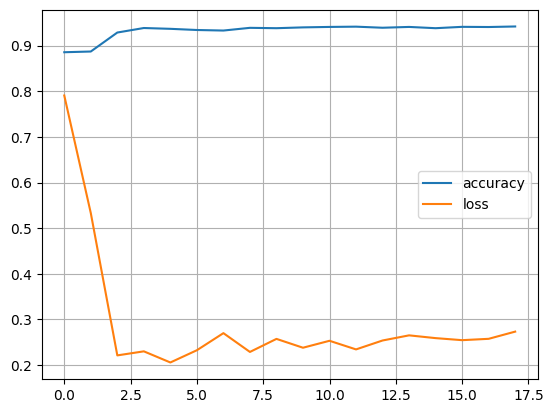

In [12]:
plt.plot(accuracy_list, label="accuracy")
plt.plot(loss_list, label="loss")
plt.legend()
plt.grid()

tensor([1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')


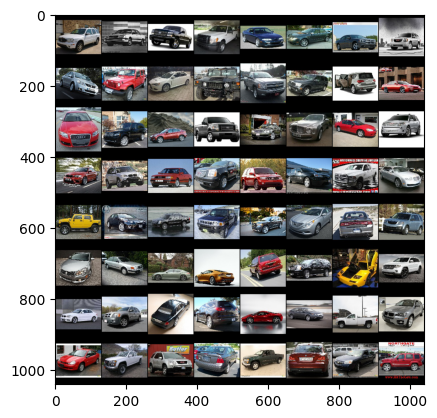

In [13]:
from torchvision.utils import make_grid

images, labels = next(iter(dl_valid))

inputs = images.to(device)
net.eval()
with torch.no_grad():
    outputs = net(inputs)
    _, preds = torch.max(outputs, 1)
    print(preds)

plt.imshow(make_grid(images).numpy().transpose((1, 2, 0)))